In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2 ## pip install opencv-python
import os 
import sys
import pathlib
# Display various sample files from each class
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Monkey Dataset



```
Label mapping:
n0, alouatta_palliata
n1, erythrocebus_patas
n2, cacajao_calvus 
n3, macaca_fuscata   
n4, cebuella_pygmea
n5, cebus_capucinus
n6, mico_argentatus
n7, saimiri_sciureus 
n8, aotus_nigriceps
n9, trachypithecus_johnii
```

In [ ]:
data_dir = pathlib.Path(r"C:\Arihant\Personal\Mentorship\UpGrad\CNNSession")
image_count = len(list(data_dir.glob('**/*/*.jpg')))
image_count

0

In [ ]:
data_dir

PosixPath('C:\\Arihant\\Personal\\Mentorship\\UpGrad\\CNNSession')

In [ ]:
#str(list(data_dir.glob('training')))

str(list(data_dir.glob('training'))[0])

'[]'

In [ ]:
# Finding all the class names for the image classification task
CLASS_NAMES = np.array([item.name for item in data_dir.glob('training/*')])
CLASS_NAMES

array(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
      dtype='<U2')

In [ ]:
data_dir

WindowsPath('C:/Arihant/Personal/Mentorship/UpGrad/CNNSession')

In [ ]:
# Tensorflow way
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

batch_size = 32
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
img_height = 180 # This should map with the height and width of the pretrained model
img_width = 180 # This should map with the height and width of the pretrained model


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 11 classes.
Using 8012 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 11 classes.
Using 2003 files for validation.


In [ ]:
# Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32 
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 600 # This should map with the height and width of the pretrained model
IMG_WIDTH = 450 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(list(data_dir.glob('training'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1098 images belonging to 10 classes.


In [ ]:
# We can inspect how a batch is created
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        # plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

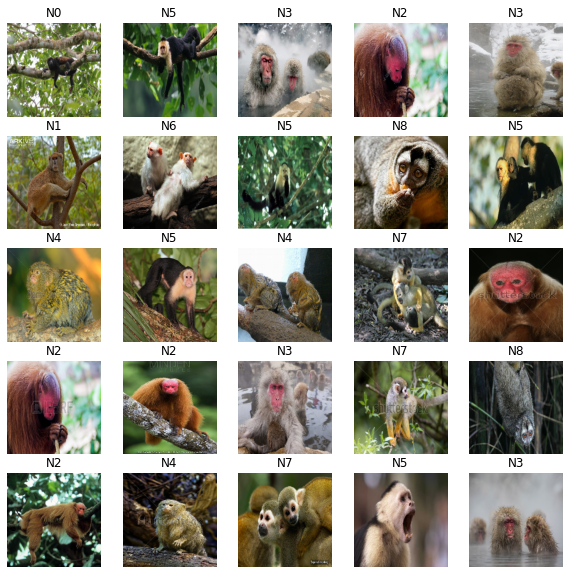

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'training/*/*'))

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img_new(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def processing_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img_new(img)
    return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(processing_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False  True False]


In [ ]:
def prepare_for_training(ds,shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    return ds

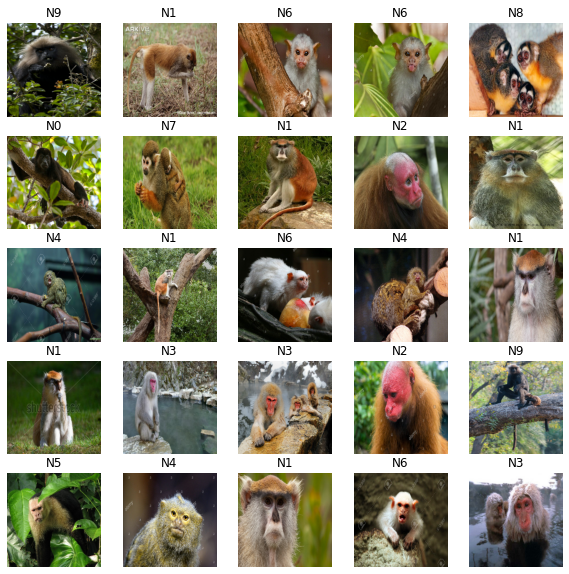

In [ ]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data


BATCH_SIZE = 2
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 224 # This should map with the height and width of the pretrained model
IMG_WIDTH = 224 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [ ]:
train_data_gen = train_image_generator.flow_from_directory(directory=str(list(data_dir.glob('training'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1098 images belonging to 10 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(directory=str(list(data_dir.glob('validation'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 272 images belonging to 10 classes.


In [ ]:
TOTAL_TRAIN = len(list(data_dir.glob('training/*/*.jpg')))
TOTAL_VAL = len(list(data_dir.glob('validation/*/*.jpg')))
EPOCHS = 1


In [ ]:
TOTAL_TRAIN

1096